In [95]:
!pip install openpyxl

import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as st 
from config import geoapify_key
import json
import requests
import pprint
import hvplot.pandas
import numpy as np

In [96]:
state_df = pd.read_excel("../Datasets/StateAndCategory.xlsx", sheet_name=0, header=1)

#this dataset has a bunch of missing values so we drop them but there is still plenty to work with
state_df = state_df.dropna()

state_df.head()

,Date,State,Category,Dollars,Unit sales,Volume sales,Dollars last year,Unit sales last year,Volume sales last year,Dollars 3 years ago,Unit sales 3 years ago,Volume sales 3 years ago,Percent change dollars 1 year,Percent change units 1 year,Percent change volume 1 year,Percent change dollars 3 years,Percent change units 3 years,Percent change volume 3 years
104,2021-10-03,Alabama,Alcohol,25122525.0,2890663.0,791668.0,26233675.0,3048993.0,863475.0,22435659.0,2976745.0,814795.0,-4.2,-5.2,-8.3,12.0,-2.9,-2.8
105,2021-10-10,Alabama,Alcohol,25482173.0,2893769.0,806014.0,25100287.0,2959385.0,832191.0,23309843.0,2977404.0,854999.0,1.5,-2.2,-3.1,9.3,-2.8,-5.7
106,2021-10-17,Alabama,Alcohol,25112476.0,2889843.0,793997.0,25267347.0,2977838.0,835216.0,21063269.0,2744731.0,765890.0,-0.6,-3.0,-4.9,19.2,5.3,3.7
107,2021-10-24,Alabama,Alcohol,24352424.0,2802999.0,768177.0,24786852.0,2912169.0,815074.0,20183470.0,2650938.0,713505.0,-1.8,-3.7,-5.8,20.7,5.7,7.7
108,2021-10-31,Alabama,Alcohol,24521451.0,2802072.0,769286.0,26436185.0,3080070.0,867819.0,22560881.0,2883969.0,801436.0,-7.2,-9.0,-11.4,8.7,-2.8,-4.0


Which state eats the healthiest?

First, let's consider what it means to eat healthy, and what this dataset can tell us about that by looking at the categories.

In [97]:
state_df["Category"].unique()

array(['Alcohol', 'Beverages', 'Dairy', 'Fats and oils', 'Fruits',
       'Grains', 'Meats, eggs, and nuts', 'Other', 'Sugar and sweeteners',
       'Vegetables'], dtype=object)

We know that some of these things are definitely unhealthy: Alcohol and Sugar and Sweeteners. Let's see which states buy the most of those. We will look at unit sales instead of dollar amounts since prices can vary a lot from state to state.

/var/folders/mw/zjkpp1qs79dgw3r0cj69_8s00000gn/T/ipykernel_18464/380225619.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  alcohol_by_state = alcohol.groupby(alcohol["State"]).sum()["Unit sales"]


(0.0, 1118962187.2)

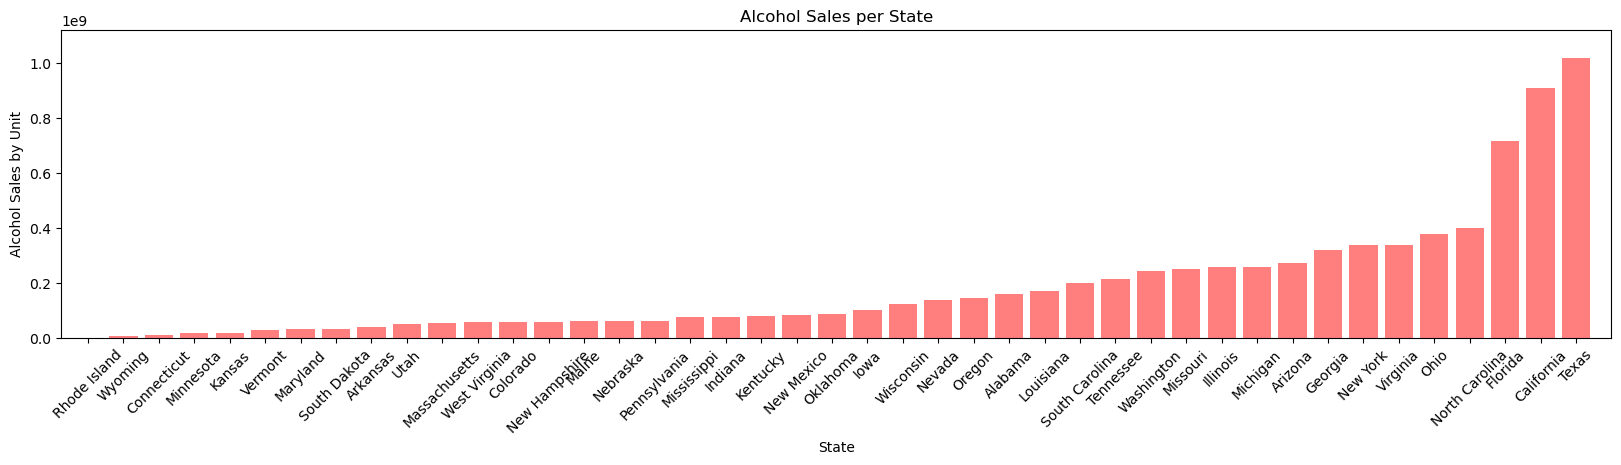

In [145]:
alcohol = state_df.loc[state_df["Category"] == "Alcohol"]
alcohol_by_state = alcohol.groupby(alcohol["State"]).sum()["Unit sales"]
alcohol_by_state = alcohol_by_state.sort_values()

x_axis = np.arange(len(alcohol_by_state))
tick_locations = [value for value in x_axis]

plt.figure(figsize=(20,4))
plt.bar(x_axis, alcohol_by_state, color='r', alpha=0.5, align="center")
plt.xticks(tick_locations, alcohol_by_state.index, rotation=45)

plt.title("Alcohol Sales per State")
plt.xlabel("State")
plt.ylabel("Alcohol Sales by Unit")

plt.xlim(-0.75, len(x_axis))
plt.ylim(0, max(alcohol_by_state)*1.1)

That is interesting - at first glance, it looks a lot like the states might just be ranked by population, but they aren't. Texas managed to take the top spot. Hats off!

/var/folders/mw/zjkpp1qs79dgw3r0cj69_8s00000gn/T/ipykernel_18464/1217285637.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  sugar_by_state = sugar.groupby(sugar["State"]).sum()["Unit sales"]


(0.0, 85189418.60000001)

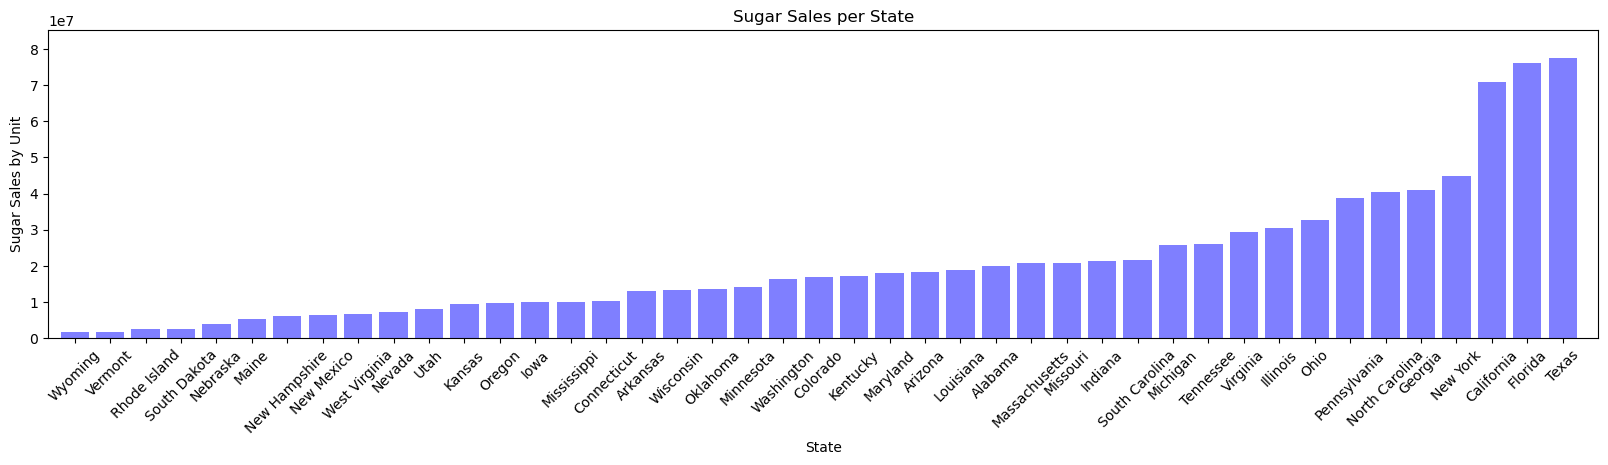

In [146]:
sugar = state_df.loc[state_df["Category"] == "Sugar and sweeteners"]
sugar_by_state = sugar.groupby(sugar["State"]).sum()["Unit sales"]
sugar_by_state = sugar_by_state.sort_values()

x_axis = np.arange(len(sugar_by_state))
tick_locations = [value for value in x_axis]

plt.figure(figsize=(20,4))
plt.bar(x_axis, sugar_by_state, color='b', alpha=0.5, align="center")
plt.xticks(tick_locations, sugar_by_state.index, rotation=45)

plt.title("Sugar Sales per State")
plt.xlabel("State")
plt.ylabel("Sugar Sales by Unit")

plt.xlim(-0.75, len(x_axis))
plt.ylim(0, max(sugar_by_state)*1.1)

This time, we see a another surprise - both Texas and Florida are above the most populous state, California. They like it sweet in the south!

Even though these unexpected results from the raw volume data are interesting, they also make it clear that we should try to control a bit for population size as we compare the states.

So let's get back to our original question - which state eats the healthiest? - by pulling in some data that will help us look at per capita spending.

In [6]:
#we will use US Census estimates from 2021 to get each state's population

state_pops = pd.read_csv("../Datasets/census_state_pops.csv")
state_pops = state_pops[["NAME","POPESTIMATE2021"]]

Now we turn our attention to vegetables. We will use vegetables as our first proxy for healthy eating. Our assumption is that the more you eat vegetables, the more you are making an effort to eat healthy. 

In [147]:
#get a vegetable specific dataframe

vegetables = state_df.loc[state_df["Category"] == "Vegetables"]
vegetables_by_state = vegetables.groupby(vegetables["State"]).sum()["Unit sales"]
vegetables_by_state = vegetables_by_state.sort_values(ascending=False)
vegetables_by_state = pd.DataFrame(vegetables_by_state)

/var/folders/mw/zjkpp1qs79dgw3r0cj69_8s00000gn/T/ipykernel_18464/50392405.py:4: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  vegetables_by_state = vegetables.groupby(vegetables["State"]).sum()["Unit sales"]


Let's use the population data we just pulled in to calculate per capita consumption, by dividing the sales by volume by population. Again, we are assuming that the more vegetables someone consumes, the more they are eating healthy, so let's look at that state by state.

In [148]:
#add a calculated per capita consumption column

veggies = pd.merge(state_pops,vegetables_by_state,how='right',left_on='NAME',right_on='State')
veggies["Veggies_per_capita"] = veggies["Unit sales"] / veggies["POPESTIMATE2021"]
veggies.columns = ["State", "Population", "Vegetable Sales by Unit", "Per Capita Veggie Consumption"]
veggies.head()

,State,Population,Vegetable Sales by Unit,Per Capita Veggie Consumption
0,California,39237836,2.747178e+09,70.013486
1,Texas,29527941,2.050460e+09,69.441341
2,Florida,21781128,1.983277e+09,91.054818
3,New York,19835913,1.206121e+09,60.804906
4,North Carolina,10551162,1.026626e+09,97.299847


Let's take advantage of the fact we are look at state level data by plotting these calculated values onto a map. To do that, we'll call an API to get each state's coordinates, and then create a plot that uses per capita consumpton for the size of the state's marker. This should give us an intuitive, at a glance, look at where people eat the most vegetables.

In [149]:
#find an API and pull in state population with a for loop

state_lons = []
state_lats = []

states = veggies["State"]

for state in states:
    url = f"https://api.geoapify.com/v1/geocode/search?state={state}&format=json&apiKey={geoapify_key}"
    response = requests.get(url).json()
    state_lon = response["results"][0]["lon"]
    state_lat = response["results"][0]["lat"]
    
    state_lons.append(state_lon)
    state_lats.append(state_lat)
    
veggies["Longitude"] = state_lons
veggies["Latitude"] = state_lats

veggies.head()

,State,Population,Vegetable Sales by Unit,Per Capita Veggie Consumption,Longitude,Latitude
0,California,39237836,2.747178e+09,70.013486,-118.755997,36.701463
1,Texas,29527941,2.050460e+09,69.441341,-98.545612,31.263890
2,Florida,21781128,1.983277e+09,91.054818,-81.463983,27.756767
3,New York,19835913,1.206121e+09,60.804906,-75.844995,43.156168
4,North Carolina,10551162,1.026626e+09,97.299847,-79.039292,35.672964


In [150]:
#make a map

veg_map = veggies.hvplot.points(
    "Longitude",
    "Latitude",
    geo = True,
    size = "Per Capita Veggie Consumption",
    scale=4,
    color = "Per Capita Veggie Consumption",
    hover_cols = "State"
)

veg_map

:Points   [Longitude,Latitude]   (Per Capita Veggie Consumption,State)

That's neat! But with all this data, we can go a bit further and get a better answer about which state eats the healthiest. We should go back to our definition of healthy eating. Just eating vegetables isn't enough. To eat healthy, you should also avoid those unhealthy things we looked at before. Let's try to see if there is a state where people eat lots of the good stuff and not a lot of the bad stuff. 

We'll start by making a new dataframe that will allow us to do some basic statistical analysis of per capita consumption across the categories of interest.

In [151]:
alcohol = state_df.loc[state_df["Category"] == "Alcohol"]
alcohol_by_state = alcohol.groupby(alcohol["State"]).sum()["Unit sales"]

sugar = state_df.loc[state_df["Category"] == "Sugar and sweeteners"]
sugar_by_state = sugar.groupby(sugar["State"]).sum()["Unit sales"]

vegetables = state_df.loc[state_df["Category"] == "Vegetables"]
vegetables_by_state = vegetables.groupby(vegetables["State"]).sum()["Unit sales"]

fruits = state_df.loc[state_df["Category"] == "Fruits"]
fruits_by_state = fruits.groupby(fruits["State"]).sum()["Unit sales"]

comparison_df = pd.DataFrame({
    "Fruits": fruits_by_state,
    "Veg": vegetables_by_state,
    "Sugar": sugar_by_state,
    "Alcohol": alcohol_by_state
})

comparison_df = pd.merge(state_pops,comparison_df,how='right',left_on='NAME',right_on='State')
comparison_df["Fruits per capita"] = comparison_df["Fruits"] / comparison_df["POPESTIMATE2021"]
comparison_df["Veg per capita"] = comparison_df["Veg"] / comparison_df["POPESTIMATE2021"]
comparison_df["Sugar per capita"] = comparison_df["Sugar"] / comparison_df["POPESTIMATE2021"]
comparison_df["Alcohol per capita"] = comparison_df["Alcohol"] / comparison_df["POPESTIMATE2021"]

comparison_df.head()

/var/folders/mw/zjkpp1qs79dgw3r0cj69_8s00000gn/T/ipykernel_18464/2585128465.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  alcohol_by_state = alcohol.groupby(alcohol["State"]).sum()["Unit sales"]
/var/folders/mw/zjkpp1qs79dgw3r0cj69_8s00000gn/T/ipykernel_18464/2585128465.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  sugar_by_state = sugar.groupby(sugar["State"]).sum()["Unit sales"]
/var/folders/mw/zjkpp1qs79dgw3r0cj69_8s00000gn/T/ipykernel_18464/2585128465.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to 

,NAME,POPESTIMATE2021,Fruits,Veg,Sugar,Alcohol,Fruits per capita,Veg per capita,Sugar per capita,Alcohol per capita
0,Alabama,5039877,2.453778e+08,3.983798e+08,19946438.0,159460362.0,48.687251,79.045535,3.957723,31.639733
1,Arizona,7276316,4.825447e+08,7.747813e+08,18307811.0,273226348.0,66.317174,106.479883,2.516082,37.550094
2,Arkansas,3025891,1.526280e+08,2.837598e+08,12949898.0,40821068.0,50.440668,93.777283,4.279697,13.490594
3,California,39237836,1.850687e+09,2.747178e+09,70953758.0,909456097.0,47.165867,70.013486,1.808299,23.178039
4,Colorado,5812069,4.066481e+08,6.169947e+08,16838378.0,57695148.0,69.966148,106.157499,2.897140,9.926783


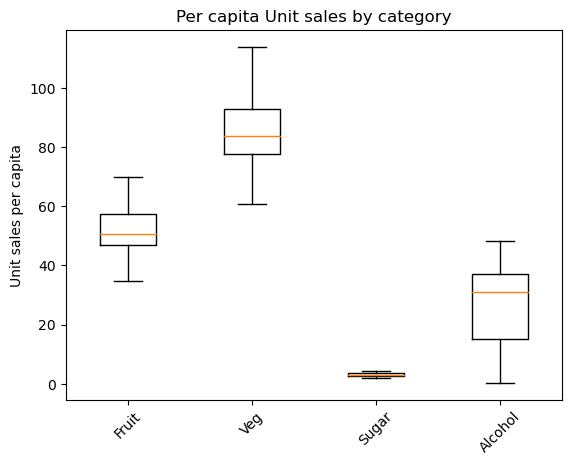

In [152]:
boxes = [comparison_df["Fruits per capita"],
         comparison_df["Veg per capita"],
         comparison_df["Sugar per capita"],
         comparison_df["Alcohol per capita"]
        ]

categories = ["Fruit", "Veg", "Sugar","Alcohol"]

fig = plt.figure()
plt.ylabel("Unit sales per capita")
plt.title("Per capita Unit sales by category")
flierprops = dict(marker='o', markerfacecolor='red', markersize=12,
                   linestyle='none')
plt.boxplot(boxes,flierprops=flierprops)
plt.xticks([1,2,3,4], categories, rotation=45)
plt.show()

This boxplot tells us a couple of things - one, overall people eat a lot more vegetables than they drink alcohol. That is reassuring! More importantly, it also shows us that there are no outliers in any of these categories - that means there's no state that's obviously the first one to look at (or to disregard).

Let's proceed to search for a state that is above average in fruit and veg consumption, and below average in sugar and alcohol.

In [153]:
#identify the median value
val_50 = comparison_df.describe().loc["50%"].to_frame().T

In [154]:
#search for states that meet our criteria

comparison_df[(comparison_df["Fruits per capita"]>=val_50["Fruits per capita"][0]) 
              & (comparison_df["Veg per capita"]>=val_50["Veg per capita"][0])
              & (comparison_df["Sugar per capita"]<=val_50["Sugar per capita"][0])
              & (comparison_df["Alcohol per capita"]<=val_50["Alcohol per capita"][0])
             ]

,NAME,POPESTIMATE2021,Fruits,Veg,Sugar,Alcohol,Fruits per capita,Veg per capita,Sugar per capita,Alcohol per capita
4,Colorado,5812069,406648081.0,616994710.0,16838378.0,57695148.0,69.966148,106.157499,2.897140,9.926783
5,Connecticut,3605597,209886788.0,329571190.0,10203508.0,10506302.0,58.211383,91.405443,2.829908,2.913887


Two states passed our test for healthy eating! Colorado has higher values for the desirable attributes, but also for the undesirable ones. Connecticut has lower values all across the board. 